In [1]:
library(dplyr)
library(tidyverse)
library(data.table)
library(bedr)
library(readr)
library(susieR)
options(readr.num_columns = 0)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"'timedatectl' indicates the non-existent timezone name 'n/a'"
unable to deduce timezone name from 'America/Chicago'

-- Attaching packages ------------------------------------------------------------------------------------------------------------------------------------------------------ tidyverse 1.3.1 --

v ggplot2 3.4.1     v purrr   0.3.4
v tibble  3.2.1     v stringr 1.4.0
v tidyr   1.1.3     v forcats 0.5.1
v readr   1.4.0     

-- Conflicts --------------------------------------------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'data.table'


The following object is masked from 

In [2]:
dir.create(tempdir())

dir <- "/project2/yangili1/bjf79/ChromatinSplicingQTLs/"
colocs <- read_tsv(paste0(dir, "output/GwasColocs_by_MolQTLCategory_ForCarlos.All.tsv.gz"))

colocs <-  colocs %>% mutate(
    Trait_name = Trait %>% str_extract(., "(?<=;)[^;]+$")
    )

colocs_ <- colocs %>% filter(ColocCategory == 'sQTL+eQTL colocs', PosteriorColocalizationPr >= 0.2)

colocs_ <- colocs_ %>% mutate(Gene = "")
colocs_ <- colocs_ %>% group_by(GWAS.Loci) %>% 
  mutate(
    Gene = if_else(
      as.character(PhenotypeClass) %in% c("Expression.Splicing", "chRNA.Expression.Splicing"), 
      as.character(Trait_name),#paste(unique(Trait_name), collapse = ";"), 
      first(colocs_[colocs_$GWAS.Loci == cur_group()[["GWAS.Loci"]] & 
                 (colocs_$PhenotypeClass == "Expression.Splicing" |
                    colocs_$PhenotypeClass == "chRNA.Expression.Splicing"), "Trait_name"]) %>% 
        pull()
    )
  ) %>% 
  ungroup()


gene_bed <- read_tsv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', 
                     col_names = c('chrom', 'start', 'end', 'gene_name', 'score', 'strand') )

gene_list <- colocs_ %>% filter(PhenotypeClass == 'GWAS')  %>% pull(Gene) %>% unique()

Warning message in dir.create(tempdir()):
"'/tmp//RtmpNIwnRD' already exists"


In [3]:
process_slice_gene <- function(colocs, gene_bed, geneName){
    
    dir <- "/project2/yangili1/bjf79/ChromatinSplicingQTLs/"
    
    colocs_ <- colocs[colocs$Gene == geneName,]
    
    chrom <- gene_bed %>% filter(gene_name == geneName) %>% pull(chrom)
    start <- gene_bed %>% filter(gene_name == geneName) %>% pull(start) %>% as.integer()
    end <- gene_bed %>% filter(gene_name == geneName) %>% pull(end) %>% as.integer()
    from <- start -500001
    to <- end + 500001
    coords <- paste0(chrom, ':', as.character(from), '-', as.character(to))
    unique_traits <- colocs_$Trait %>% unique()
    
    print(unique_traits)
    
    for (trait in unique_traits) {
        assay <- gsub(';.*', '', trait)
        
        if (assay == 'GWAS'){
            
            gwas_chr_pos_name <- gsub('.*;', '', trait)
            
            gwas_chr_pos_name_split <- strsplit(gwas_chr_pos_name, "_")[[1]]
            
            
            GWAS_SNP_pos <- gwas_chr_pos_name_split[2]
            gwas_name <- gwas_chr_pos_name_split[3]
            
            gwas_locus_name <- gwas_chr_pos_name %>% gsub("_GCS", "_N_N_GCS", .)
            gwas_locus <- get_gwas_locus(gwas_name, gwas_locus_name)
            

            gwas_x <- gwas_locus %>% pull(start) %>% as.integer()
            gwas_y <- gwas_locus %>% pull(P) %>% as.numeric() %>% -log10(.)
            plot(gwas_x, gwas_y, xlab='coords', ylab=gwas_name)
            
            
            top_snp <- colocs_[colocs_$Trait==trait, 'TopCandidateSNP'][[1]]
        } else {
            
            QTL_df <- get_QTL_df(assay, coords, geneName, trait)
                        
            plot_QTL (QTL_df, assay)

        }
    }
    
    
}

get_gwas_locus <- function(gwas_name, gwas_locus_name){
    gwas_file <- paste0(dir, 'code/gwas_summary_stats/StatsForColoc/', gwas_name, '.unstandardized.txt.gz')
    
    zcat_awk_cmd <- sprintf("zcat %s | awk -F '\\t' '{if (NR==1 || $(NF-1) == \"%s\") print }' -", gwas_file, gwas_locus_name)
    
    zcat_awk_output <- system(zcat_awk_cmd, intern = TRUE)
    tmp_file <- tempfile()
    writeLines(zcat_awk_output, tmp_file)
    gwas_locus <- read_tsv(tmp_file)
    file.remove(tmp_file)
    gwas_locus$hm_variant_id <- gsub('_', ':', gwas_locus$hm_variant_id)
    return(gwas_locus)
}

get_QTL_df <- function(assay, coords, gene_locus, trait){

    phenotype_id <- paste(gsub('.*;', '', trait), gene_locus, sep=':')
    assay_file <- paste0(dir, 'code/QTLs/QTLTools/%s/NominalPassForColoc.txt.tabix.gz') %>% sprintf(., assay)
    phe_id <- paste()

    print(coords)
    print(assay_file)
    print(phenotype_id)
    print('======')
    QTL_df <- tabix(coords, assay_file, check.chr=FALSE, verbose=FALSE) %>%
        filter(phe_id == phenotype_id)
    return (QTL_df)
}


plot_QTL <- function(QTL_df, assay){
    QTL_df_selected <- QTL_df %>% pull(var_id)

    QTL_index <- match(QTL_df_selected, QTL_df$var_id)
    QTL_df_ <- QTL_df[QTL_index, ]

    plot_x <- QTL_df %>% pull(var_from) %>% as.integer()
    plot_QTL_y <- QTL_df_ %>% pull(nom_pval) %>% as.numeric() %>% -log10(.)
    tryCatch({
        plot(plot_x, plot_QTL_y, xlab = 'coords', ylab=assay)
    }, error=function(cond) {
            plot_QTL_y %>% length() %>% print()
        })

}


In [4]:
gene_list

[1] "ENSG00000179163.11" "ENSG00000142089.16" "ENSG00000149922.10"
 [4] "ENSG00000159314.11" "ENSG00000176681.14" "ENSG00000167468.17"
 [7] "ENSG00000125755.19" "ENSG00000128604.20" "ENSG00000132763.15"
[10] "ENSG00000122481.17" "ENSG00000123427.17" "ENSG00000010278.14"
[13] "ENSG00000166965.12" "ENSG00000206052.11" "ENSG00000183172.9" 
[16] "ENSG00000137076.21" "ENSG00000117335.20" "ENSG00000107796.13"
[19] "ENSG00000179918.19" "ENSG00000029725.17" "ENSG00000064666.15"
[22] "ENSG00000175489.10" "ENSG00000197375.13" "ENSG00000127022.15"
[25] "ENSG00000183323.13" "ENSG00000136280.17" "ENSG00000189171.14"
[28] "ENSG00000149782.11" "ENSG00000276023.5"  "ENSG00000130703.17"
[31] "ENSG00000117500.13" "ENSG00000154252.12" "ENSG00000196419.12"
[34] "ENSG00000143387.13" "ENSG00000183955.13" "ENSG00000025156.13"
[37] "ENSG00000056558.11" "ENSG00000072682.18" "ENSG00000204160.12"
[40] "ENSG00000111321.11" "ENSG00000103222.19" "ENSG00000166913.13"
[43] "ENSG00000110871.15" "ENSG00000185829.18" "ENSG00000166845.15"
[46] "ENSG00000167074.15" "ENSG00000013364.19" "ENSG00000091640.8" 
[49] "ENSG00000171574.18" "ENSG00000124134.9"  "ENSG00000097046.13"
[52] "ENSG00000135956.9"  "ENSG00000160294.11" "ENSG00000111846.18"
[55] "ENSG00000176978.14" "ENSG00000166532.16" "ENSG00000165879.9" 
[58] "ENSG00000137806.9"  "ENSG00000115459.18" "ENSG00000134070.5" 
[61] "ENSG00000184293.7"  "ENSG00000186193.9"  "ENSG00000090621.14"
[64] "ENSG00000175634.15" "ENSG00000128829.12" "ENSG00000099381.18"
[67] "ENSG00000167720.13" "ENSG00000177989.13" "ENSG00000156711.17"
[70] "ENSG00000179526.17" "ENSG00000169231.13" "ENSG00000076067.13"
[73] "ENSG00000096070.19" "ENSG00000183828.15" "ENSG00000141002.20"
[76] "ENSG00000104804.8"  "ENSG00000106100.11" "ENSG00000066084.13"
[79] "ENSG00000141504.12" "ENSG00000105136.20" "ENSG00000025708.14"
[82] "ENSG00000141295.14" "ENSG00000167671.12" "ENSG00000175643.10"
[85] "ENSG00000051825.15" "ENSG00000120659.15" "ENSG00000063176.16"
[88] "ENSG00000100412.16" "ENSG00000108406.10" "ENSG00000116171.19"
[91] "ENSG00000130511.16" "ENSG00000164938.14" "ENSG00000064547.14"
[94] "ENSG00000125319.14" "ENSG00000160959.8"

[1] "Expression.Splicing;ENSG00000179163.11"      
[2] "polyA.Splicing;1:23875662:23879504:clu_449_-"
[3] "polyA.Splicing;1:23879604:23913246:clu_449_-"
[4] "GWAS;chr1_23872874_GCST004606"               
[5] "GWAS;chr1_23873379_GCST004617"               
[6] "GWAS;chr1_23829795_GCST004628"               
[7] "GWAS;chr1_23873379_GCST004600"               
[1] "chr1:23345075-24368295"
[1] "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/Expression.Splicing/NominalPassForColoc.txt.tabix.gz"
[1] "ENSG00000179163.11:ENSG00000179163.11"
[1] "======"
[1] "chr1:23345075-24368295"
[1] "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/polyA.Splicing/NominalPassForColoc.txt.tabix.gz"
[1] "1:23875662:23879504:clu_449_-:ENSG00000179163.11"
[1] "======"


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


[1] 0
[1] "chr1:23345075-24368295"
[1] "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/polyA.Splicing/NominalPassForColoc.txt.tabix.gz"
[1] "1:23879604:23913246:clu_449_-:ENSG00000179163.11"
[1] "======"


Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


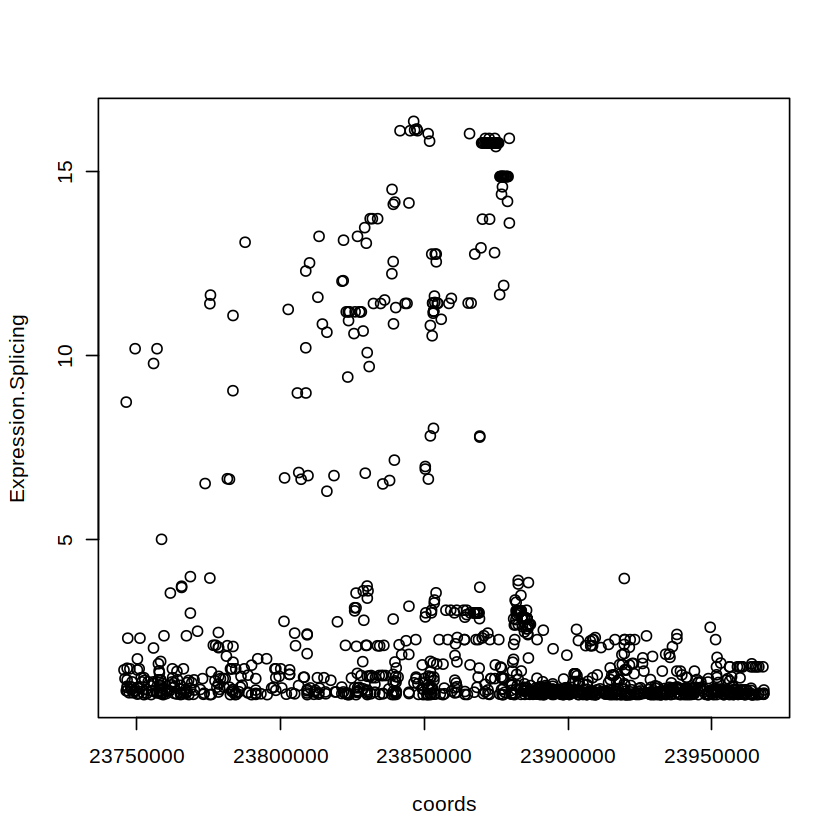

[1] 0


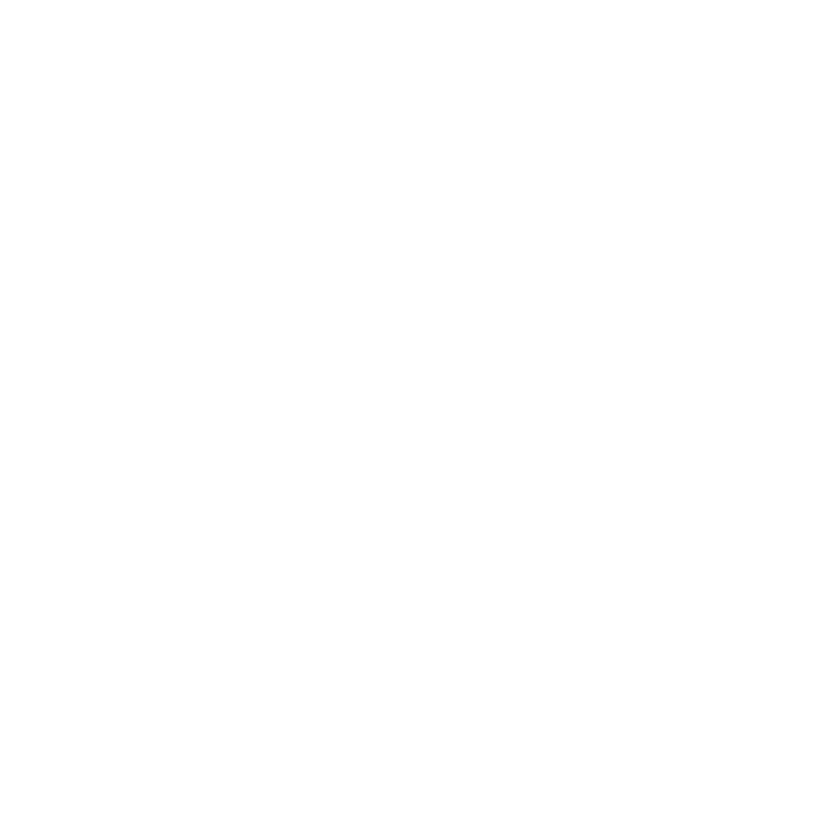

In [67]:
process_slice_gene(colocs_, gene_bed, geneName='ENSG00000179163.11')

In [5]:
nominal.gene <- tabix("chr1:22345075-25368295", "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/Expression.Splicing/NominalPassForColoc.txt.tabix.gz", check.chr=FALSE, verbose=FALSE) %>%
        filter(phe_id == 'ENSG00000141504.12:ENSG00000141504.12')

In [6]:
finemap.gene <- function(colocs_, geneName, seed=123){
    set.seed(seed)
    coords <- get_coords(colocs_, geneName)
    nominal.gene <- get.nominal.gene(coords, geneName)
    GT <- get.genotype("../code/FineMapping/Genotypes/1KG_GRCh38/Geuvadis.txt.bgz", coords)
    GT.filtered <- filter.GT(nominal.gene, GT)
    nominal.gene <- GT.filtered$nominal.gene
    GT <- GT.filtered$GT
    susie.input <- prepare.susie.input(nominal.gene, GT)
    susie.output <- run.susie(susie.input)
    
    return(
        list(
            susie.output = susie.output,
            GT = GT,
            nominal.gene <- nominal.gene,
            coords = coords
        )
    )
}

get_coords <- function(colocs_, geneName){
    Trait_ <- paste0('Expression.Splicing;', geneName)
    df_slice <- colocs_ %>% filter(Trait==Trait_, Gene==geneName)
    chrom <- df_slice %>% pull(GWAS.LeadSNP.Chrom)
    pos <- df_slice %>% pull(GWAS.LeadSNP.Pos) %>% as.integer()
    start <- max(pos - 1000000, 0) %>% as.character()
    end <- (pos + 1000000) %>% as.character()
    pos_str <- paste(start, end, sep='-')
    coords <- paste(chrom, pos_str, sep=':')
    
    if (length(coords) > 1){
        coords <- coords[1]
    }
    return(coords)
}

get.nominal.slice <- function(coords, nominal.file, phe_id_){
    print(coords)
    print(nominal.file)
    QTL_df <- tabix(coords, nominal.file, check.chr=FALSE, verbose=FALSE) %>%
        filter(phe_id == phe_id_)
    return(QTL_df)
}

get.nominal.gene <- function(coords, gene){
    qtltools.dir <- "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/"
    nominal.file <- paste0(qtltools.dir, "Expression.Splicing/NominalPassForColoc.txt.tabix.gz")
    phe_id <- paste(gene, gene, sep=':')
    QTL_df <- get.nominal.slice(coords, nominal.file, phe_id)
    return(QTL_df)
}

get.genotype <- function(genotype, coords){
    coords_gsub <- gsub('*chr', '', coords)
    head_cmd <- paste("zcat", genotype, "| head")
    header <- fread(cmd = str_glue(head_cmd),
                      data.table = F, header = T) %>% colnames()
    samples <- header[6:length(header)]
    tabix_cmd <- paste("tabix", genotype, coords_gsub)
    GT <- fread(cmd = str_glue(tabix_cmd),
                  data.table = F, header = F)
    colnames(GT) <- header
    GT <- GT[rowSums(GT[,samples]) > 0,]
    return(GT)
    
}

filter.GT <- function(nominal.gene, GT){
    GT <- GT %>% filter(ID %in% nominal.gene$var_id)
    nominal.gene <- nominal.gene %>% filter(var_id %in% GT$ID)
    return (list(GT=GT, nominal.gene=nominal.gene))
}

genotype.cor <- function(GT){
    XCor <- cor(t(GT[,colnames(GT[6:dim(GT)[2]])]))
    return(XCor)
}

prepare.susie.input <- function(nominal.gene, GT){
    slope <- nominal.gene$slope %>% as.numeric()
    slope_se <- nominal.gene$slope_se %>% as.numeric()
    Z <- (slope / slope_se)
    n <- dim(GT)[2] - 5
    XCor <- genotype.cor(GT)
    return(list(Z=Z, XCor=XCor, n=n))
}

run.susie <- function(susie.input){
    Z <- susie.input$Z
    XCor <- susie.input$XCor
    n <- susie.input$n
    
    susie_out <- susie_rss(Z, XCor, L=10, n=n,
                       estimate_prior_variance = FALSE,
                       scaled_prior_variance = 1,
                       min_abs_corr = 0.1,
                       verbose = TRUE)
    return(susie_out)
}

In [7]:
dir.create(tempdir())

aver <- finemap.gene(colocs_, 'ENSG00000179163.11')

Warning message in dir.create(tempdir()):
"'/tmp//RtmpNIwnRD' already exists"


[1] "chr1:22873379-24872874"
[1] "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/Expression.Splicing/NominalPassForColoc.txt.tabix.gz"
[1] "objective:-633.042914301682"
[1] "objective:-632.577660128594"
[1] "objective:-632.455045720468"
[1] "objective:-632.421269102675"
[1] "objective:-632.414184731432"
[1] "objective:-632.412428163833"
[1] "objective:-632.411794901734"


In [8]:
aver$susie.output$sets$cs#$L1

$L1
 [1] 325 349 359 360 362 366 367 382 392 468 498 501 502 505 508 509 510 511 512
[20] 513 517 518 519 520 524 525 526 527 529 531 532 533 534 535 536 537 538 539
[39] 540 542 543 544 546 547 549 550 551 552 553 554 555 559 560 563 567 568 589

In [60]:
nominal.gene[aver$susie.output$sets$cs$L1,]

,phe_id,phe_chr,phe_from,phe_to,phe_strd,n_var_in_cis,dist_phe_var,var_id,var_chr,var_from,var_to,nom_pval,r_squared,slope,slope_se,best_hit
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
282,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7565371:G:T,chr17,7565371,7565371,7.39009e-18,0.152934,0.197153,0.0219461,0
371,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7588592:G:A,chr17,7588592,7588592,1.06153e-17,0.151576,0.197158,0.0220623,0
379,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7591027:CTCT:C,chr17,7591027,7591030,8.15329e-18,0.152565,0.198045,0.0220767,0
381,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7594873:C:T,chr17,7594873,7594873,6.35398e-18,0.153499,0.198776,0.0220785,0
411,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7600742:G:C,chr17,7600742,7600742,6.35398e-18,0.153499,0.198776,0.0220785,0
510,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7617969:AG:A,chr17,7617969,7617970,3.46302e-18,0.155768,0.20053,0.022081,0
539,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7622230:C:G,chr17,7622230,7622230,3.46302e-18,0.155768,0.20053,0.022081,0
560,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7626829:G:C,chr17,7626829,7626829,6.2756e-19,0.162122,0.205212,0.0220657,0
561,ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7626953:C:T,chr17,7626953,7626953,5.31552e-18,0.154167,0.198716,0.0220154,0


In [58]:
aver$GT[aver$susie.output$sets$cs$L1,]

,#CHROM,POS,ID,REF,FORMAT,HG00096,HG00097,HG00099,HG00100,HG00101,⋯,NA20809,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20819,NA20826,NA20828
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
282,17,7565371,17:7565371:G:T,G,GT,0,0,0,0,1,⋯,0,1,0,1,1,1,0,1,0,0
371,17,7588592,17:7588592:G:A,G,GT,0,0,0,0,1,⋯,0,1,0,1,1,1,0,1,0,0
379,17,7591027,17:7591027:CTCT:C,CTCT,GT,0,0,0,0,1,⋯,0,1,0,1,1,1,0,1,0,0
381,17,7594873,17:7594873:C:T,C,GT,0,0,0,0,1,⋯,0,1,0,1,1,1,0,1,0,0
411,17,7600742,17:7600742:G:C,G,GT,0,0,0,0,1,⋯,0,1,0,1,1,1,0,1,0,0
510,17,7617969,17:7617969:AG:A,AG,GT,0,0,0,0,1,⋯,0,1,0,0,1,1,0,1,0,0
539,17,7622230,17:7622230:C:G,C,GT,0,0,0,0,1,⋯,0,1,0,0,1,1,0,1,0,0
560,17,7626829,17:7626829:G:C,G,GT,0,0,0,0,1,⋯,0,1,0,0,1,1,0,1,0,0
561,17,7626953,17:7626953:C:T,C,GT,0,0,0,0,1,⋯,0,1,0,0,1,1,0,1,0,0


In [9]:
get_LD_vector <- function(X, i, getLD_func) {
  ld_vector <- apply(X, 1, getLD_func, X[i, ])
  return(ld_vector)
}

getLD <- function(genotype1, genotype2){
    pa <- (genotype1 == 0) %>% mean()
    pA <- (genotype1 > 0) %>% mean()
    pb <- (genotype2 == 0) %>% mean()
    pB <- (genotype2 > 0) %>% mean()


    pAB <- ((genotype1 > 0) & (genotype2 > 0)) %>% mean()
    pab <- ((genotype1 == 0) & (genotype2 == 0)) %>% mean()
    paB <- ((genotype1 == 0) & (genotype2 > 0)) %>% mean()
    pAb <- ((genotype1 > 0) & (genotype2 == 0)) %>% mean()

    D <- ((pAB*pab) - (paB*pAb))**2

    r2 <- D/(pa*pA*pb*pB)
    return(r2)
}


In [12]:
coords <- 'chr17:6591925-8592071'

assay_file <- paste0(dir, 'code/QTLs/QTLTools/Expression.Splicing/NominalPassForColoc.txt.tabix.gz')

# tabix_cmd <- paste("tabix", genotype, position)

nominal.slice <- tabix(coords, assay_file, check.chr=FALSE, verbose=FALSE) %>% 
filter(phe_id == 'ENSG00000141504.12:ENSG00000141504.12')

In [13]:
LD_scores <- get_LD_vector(aver$GT, 560, getLD) 

In [14]:
a <- nominal.slice  %>% pull(nom_pval) %>% 
  as.numeric() %>% -log10(.) 
library(viridis)
df <- data.frame(x=1:length(a), y=a, z=LD_scores)



ggplot(df, aes(x = 1:length(a), y = a, color = LD_scores)) +
  geom_point() + 
scale_color_viridis() + xlab('coords') + ylab('-log10 pvalue')

Loading required package: viridisLite



ERROR: Error in data.frame(x = 1:length(a), y = a, z = LD_scores): arguments imply differing number of rows: 1205, 1251


In [ ]:

color_pal <- c("darkblue", "skyblue", "darkgreen", "gold", "red")

color_factor <- cut(df$z, breaks = c(0, 0.2, 0.4, 0.6, 0.8, Inf), labels = color_pal)

scatterplot <- ggplot(df, aes(x = x, y = y, color = color_factor)) +
  geom_point() +
  scale_color_manual(values = color_pal) +
  xlab('coords') + ylab('-log10 pvalue') +
  guides(color = FALSE)  # add this line to remove the color legend




colors <- data.frame(color = c("red", "gold", "darkgreen", "skyblue", "darkblue"))

squares <- ggplot(colors, aes(x = -1, y = -1, fill = color)) +
  geom_rect(aes(ymin = -1, ymax = -2, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -2, ymax = -3, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -3, ymax = -4, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -4, ymax = -5, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -5, ymax = -6, xmin = 0.5, xmax = 1.5), color = "black") +
  scale_fill_manual(values = colors$color, name = "r2", labels = c("1", "0.8", "0.6", "0.4", "0.2")) +
  coord_fixed(ylim = c(12, 6), xlim = c(12, 2)) +
  theme_void()


plot <- scatterplot + annotation_custom(ggplotGrob(squares), xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf)
plot


In [ ]:
library(ggplot2)
library(gridExtra)

color_pal <- c("darkblue", "skyblue", "darkgreen", "gold", "red")

color_factor <- cut(df$z, breaks = c(0, 0.2, 0.4, 0.6, 0.8, Inf), labels = color_pal)

scatterplot <- ggplot(df, aes(x = x, y = y, color = color_factor)) +
  geom_point(size = 3) +
  scale_color_manual(values = color_pal) +
  xlab('coords') + ylab('-log10 pvalue') +
  guides(color = FALSE) +
  theme_bw() +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())

colors <- data.frame(color = c("red", "gold", "darkgreen", "skyblue", "darkblue"))

squares <- ggplot(colors, aes(x = -1, y = -1, fill = color)) +
  geom_rect(aes(ymin = -1, ymax = -2, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -2, ymax = -3, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -3, ymax = -4, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -4, ymax = -5, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -5, ymax = -6, xmin = 0.5, xmax = 1.5), color = "black") +
  scale_fill_manual(values = colors$color, name = "r2", labels = c("1", "0.8", "0.6", "0.4", "0.2")) +
  coord_fixed(ylim = c(5, 3), xlim = c(5, 1)) +
  theme_void() +
  theme(legend.position = c(0.95, 0.5))

plot <- scatterplot + annotation_custom(ggplotGrob(squares), xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf)
plot


In [ ]:
susie_plot(aver$susie.output, y="PIP")


In [15]:
dir.create(tempdir())

aver <- finemap.gene(colocs_, 'ENSG00000179163.11')

Warning message in dir.create(tempdir()):
"'/tmp//RtmpNIwnRD' already exists"


[1] "chr1:22873379-24872874"
[1] "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/Expression.Splicing/NominalPassForColoc.txt.tabix.gz"
[1] "objective:-633.042914301682"
[1] "objective:-632.577660128594"
[1] "objective:-632.455045720468"
[1] "objective:-632.421269102675"
[1] "objective:-632.414184731432"
[1] "objective:-632.412428163833"
[1] "objective:-632.411794901734"


In [117]:
aver$coords

[1] "chr1:22873379-24872874"

In [16]:
coords <- "chr1:22873379-24872874"

assay_file <- paste0(dir, 'code/QTLs/QTLTools/Expression.Splicing/NominalPassForColoc.txt.tabix.gz')

# tabix_cmd <- paste("tabix", genotype, position)

nominal.slice <- tabix(coords, assay_file, check.chr=FALSE, verbose=FALSE) %>% 
filter(phe_id == 'ENSG00000179163.11:ENSG00000179163.11')

In [17]:
nominal.gene <- tabix("chr1:22345075-25368295", "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/Expression.Splicing/NominalPassForColoc.txt.tabix.gz", check.chr=FALSE, verbose=FALSE) %>%
        filter(phe_id == 'ENSG00000179163.11:ENSG00000179163.11')

In [18]:
nominal.gene[aver$susie.output$sets$cs$L1,]

,phe_id,phe_chr,phe_from,phe_to,phe_strd,n_var_in_cis,dist_phe_var,var_id,var_chr,var_from,var_to,nom_pval,r_squared,slope,slope_se,best_hit
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
325,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23838758:G:C,chr1,23838758,23838758,2.9981e-15,0.130168,-0.330206,0.0403735,0
349,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23841529:C:T,chr1,23841529,23841529,7.64012e-17,0.144144,-0.341744,0.0393866,0
359,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23845053:C:G,chr1,23845053,23845053,7.64012e-17,0.144144,-0.341744,0.0393866,0
360,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23846275:C:CT,chr1,23846275,23846275,4.24392e-17,0.146364,-0.343352,0.0392197,1
362,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23846599:CCTTGTTGTC:C,chr1,23846599,23846614,7.26521e-17,0.144335,-0.343211,0.0395252,0
366,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23847342:C:CT,chr1,23847342,23847342,6.84597e-17,0.144559,-0.341354,0.0392756,0
367,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23847603:T:G,chr1,23847603,23847603,7.64012e-17,0.144144,-0.341744,0.0393866,0
382,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23851310:A:G,chr1,23851310,23851310,9.17128e-17,0.143453,-0.340393,0.0393412,0
392,ENSG00000179163.11:ENSG00000179163.11,chr1,23745077,23968294,-,1251,0,1:23851817:TG:T,chr1,23851817,23851818,1.46932e-16,0.141669,-0.337924,0.0393419,0


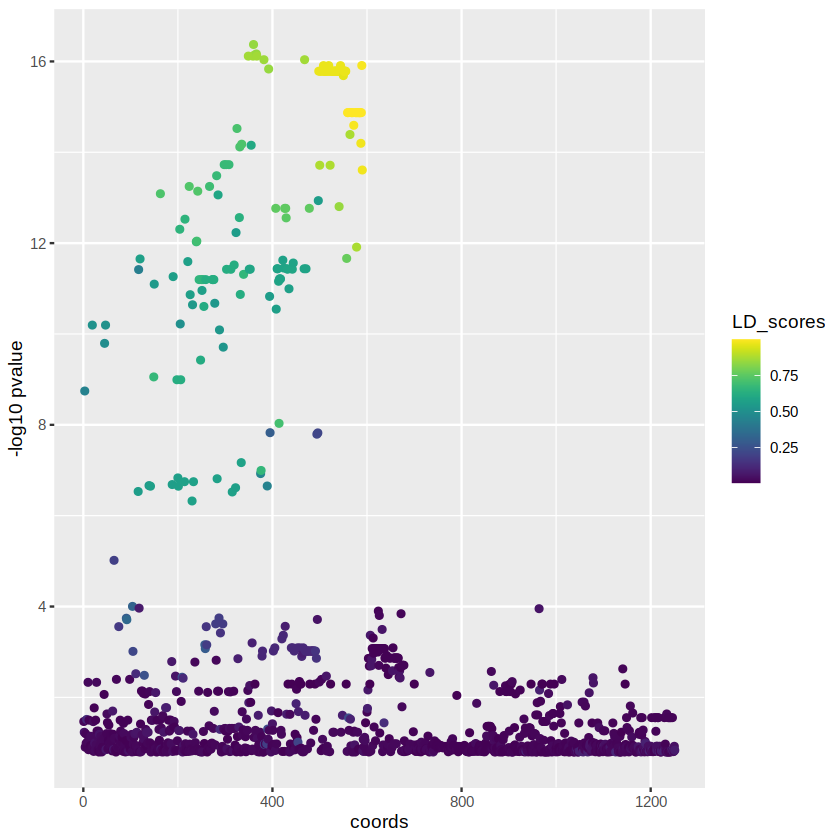

In [19]:
a <- nominal.slice  %>% pull(nom_pval) %>% 
  as.numeric() %>% -log10(.) 
library(viridis)
df <- data.frame(x=1:length(a), y=a, z=LD_scores)



ggplot(df, aes(x = 1:length(a), y = a, color = LD_scores)) +
  geom_point() + 
scale_color_viridis() + xlab('coords') + ylab('-log10 pvalue')

In [20]:
LD_scores <- get_LD_vector(aver$GT, 360, getLD) 


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4."


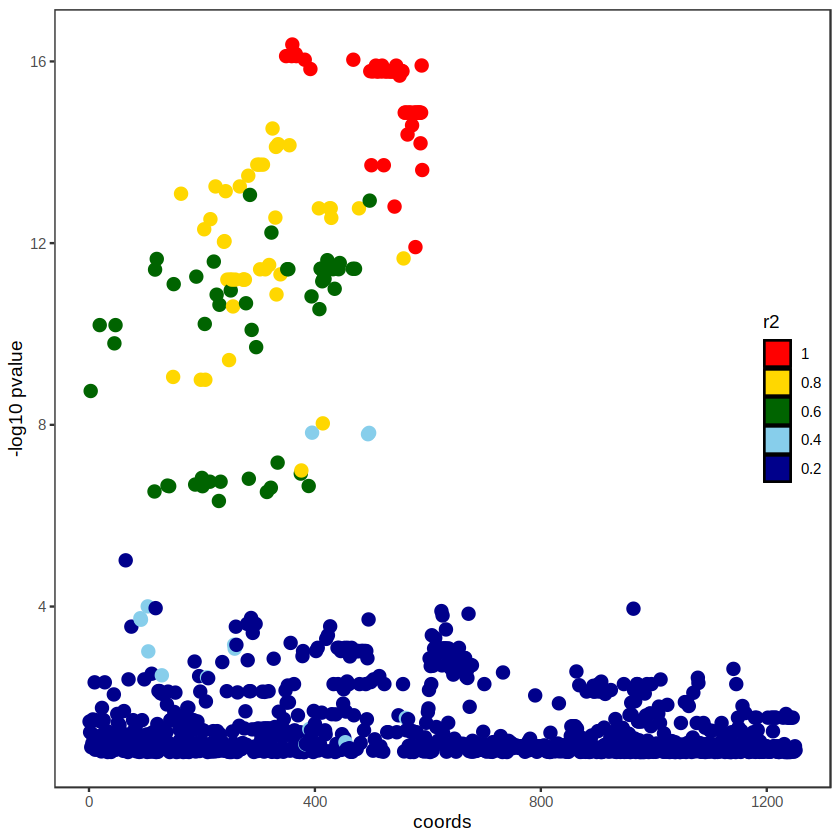

In [21]:
library(ggplot2)
library(gridExtra)

color_pal <- c("darkblue", "skyblue", "darkgreen", "gold", "red")

color_factor <- cut(df$z, breaks = c(0, 0.2, 0.4, 0.6, 0.8, Inf), labels = color_pal)

scatterplot <- ggplot(df, aes(x = x, y = y, color = color_factor)) +
  geom_point(size = 3) +
  scale_color_manual(values = color_pal) +
  xlab('coords') + ylab('-log10 pvalue') +
  guides(color = FALSE) +
  theme_bw() +
  theme(panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())

colors <- data.frame(color = c("red", "gold", "darkgreen", "skyblue", "darkblue"))

squares <- ggplot(colors, aes(x = -1, y = -1, fill = color)) +
  geom_rect(aes(ymin = -1, ymax = -2, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -2, ymax = -3, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -3, ymax = -4, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -4, ymax = -5, xmin = 0.5, xmax = 1.5), color = "black") +
  geom_rect(aes(ymin = -5, ymax = -6, xmin = 0.5, xmax = 1.5), color = "black") +
  scale_fill_manual(values = colors$color, name = "r2", labels = c("1", "0.8", "0.6", "0.4", "0.2")) +
  coord_fixed(ylim = c(5, 3), xlim = c(5, 1)) +
  theme_void() +
  theme(legend.position = c(0.95, 0.5))

plot <- scatterplot + annotation_custom(ggplotGrob(squares), xmin = -Inf, xmax = Inf, ymin = -Inf, ymax = Inf)
plot


# To do
* Yang's pLI request
* Susie
* Dongyue flu ebpmf
* EBPMF + sgom in splicing
* Finish figures, supplements, that I mentioned...
* June 6 talk

# Plot Susie
# Plot R2
# Search for secondary eQTLs in set of genes
# Search for hQTLs

In [129]:
gsub('*chr', '', coords)

[1] "17:7126232-8127877"

In [117]:
genotype <- "../code/FineMapping/Genotypes/1KG_GRCh38/Geuvadis.txt.bgz"
head_cmd <- paste("zcat", genotype, "| head")

header <- fread(cmd = str_glue(head_cmd),
                  data.table = F, header = T) %>% colnames()

samples <- header[6:length(header)]


tabix_cmd <- paste("tabix", genotype, '17:7126232-8127877')
        
GT <- fread(cmd = str_glue(tabix_cmd),
              data.table = F, header = F)

colnames(GT) <- header

GT <- GT[rowSums(GT[,samples]) > 0,]

In [118]:
X <- GT %>% filter(ID %in% nominal.gene$var_id)

nominal.gene <- nominal.gene %>% filter(var_id %in% X$ID)

In [119]:
nominal.gene %>% dim()

[1] 1205   16

In [120]:
X %>% dim()

[1] 1205  454

In [115]:
nominal.gene$var_id

[1] "17:7526314:C:T"          "17:7526743:C:A"         
   [3] "17:7527004:A:G"          "17:7527046:A:G"         
   [5] "17:7527059:G:T"          "17:7527108:C:T"         
   [7] "17:7527175:G:A"          "17:7527303:ATT:A"       
   [9] "17:7527304:AT:A"         "17:7527305:A:AT"        
  [11] "17:7527363:G:C"          "17:7527385:C:T"         
  [13] "17:7527448:T:C"          "17:7527697:G:A"         
  [15] "17:7527875:AT:A"         "17:7527886:T:A"         
  [17] "17:7527948:A:G"          "17:7527975:T:C"         
  [19] "17:7528005:G:GT"         "17:7528037:A:T"         
  [21] "17:7528039:A:T"          "17:7528199:C:T"         
  [23] "17:7528339:A:G"          "17:7528556:A:G"         
  [25] "17:7528584:C:CT"         "17:7529052:C:T"         
  [27] "17:7529235:A:C"          "17:7529316:G:A"         
  [29] "17:7529332:G:A"          "17:7529596:A:AATTATT"   
  [31] "17:7529597:A:AATT"       "17:7529837:G:A"         
  [33] "17:7530142:G:A"          "17:7530762:G:A"         
  [35] "17:7530856:T:C"          "17:7530868:C:T"         
  [37] "17:7530878:CA:C"         "17:7530879:C:CAAAAAAA"  
  [39] "17:7530880:A:C"          "17:7530922:T:C"         
  [41] "17:7530997:C:G"          "17:7531060:A:T"         
  [43] "17:7531222:CACAA:C"      "17:7531501:G:T"         
  [45] "17:7531502:A:T"          "17:7531523:CTT:C"       
  [47] "17:7531524:CT:C"         "17:7531617:G:A"         
  [49] "17:7531723:G:A"          "17:7531815:G:A"         
  [51] "17:7531900:C:T"          "17:7531974:C:A"         
  [53] "17:7532114:A:T"          "17:7532336:G:T"         
  [55] "17:7532506:G:A"          "17:7533202:A:G"         
  [57] "17:7533420:T:C"          "17:7533444:GGT:G"       
  [59] "17:7533445:GGTGT:G"      "17:7533729:G:A"         
  [61] "17:7533829:C:T"          "17:7533834:CA:C"        
  [63] "17:7533835:C:CA"         "17:7533836:C:CAA"       
  [65] "17:7533864:C:T"          "17:7534028:C:T"         
  [67] "17:7534348:A:G"          "17:7534528:T:C"         
  [69] "17:7534555:A:G"          "17:7534641:A:G"         
  [71] "17:7534733:A:G"          "17:7534781:G:A"         
  [73] "17:7534793:CA:C"         "17:7534794:CAA:C"       
  [75] "17:7535351:G:GT"         "17:7535370:A:G"         
  [77] "17:7535417:C:T"          "17:7535432:T:C"         
  [79] "17:7535466:AGACTCCC:A"   "17:7535484:G:A"         
  [81] "17:7535517:T:A"          "17:7535547:C:T"         
  [83] "17:7535603:G:T"          "17:7535697:A:G"         
  [85] "17:7535805:G:A"          "17:7535953:G:A"         
  [87] "17:7536024:T:G"          "17:7536193:A:AT"        
  [89] "17:7536338:CT:C"         "17:7536339:C:CT"        
  [91] "17:7536409:T:C"          "17:7536413:C:T"         
  [93] "17:7536422:T:C"          "17:7536437:C:G"         
  [95] "17:7536469:TG:T"         "17:7536524:T:C"         
  [97] "17:7536635:C:T"          "17:7536794:T:C"         
  [99] "17:7537267:T:C"          "17:7537362:C:T"         
 [101] "17:7537409:C:T"          "17:7537449:C:T"         
 [103] "17:7537667:C:T"          "17:7537783:G:A"         
 [105] "17:7538067:T:A"          "17:7538439:C:T"         
 [107] "17:7538440:G:A"          "17:7538459:G:T"         
 [109] "17:7538883:C:T"          "17:7538942:G:A"         
 [111] "17:7539105:A:G"          "17:7539195:T:C"         
 [113] "17:7539498:CT:C"         "17:7539742:G:C"         
 [115] "17:7539861:A:G"          "17:7539984:CTA:C"       
 [117] "17:7540006:A:G"          "17:7540104:T:TAAATAA"   
 [119] "17:7540105:T:TAAATAAATA" "17:7540106:T:A"         
 [121] "17:7540107:T:TAA"        "17:7540110:T:A"         
 [123] "17:7540125:ATATATTTT:A"  "17:7540127:ATATTTTTTT:A"
 [125] "17:7540129:ATATTTTTTT:A" "17:7540131:T:TATATA"    
 [127] "17:7540133:T:TATA"       "17:7540196:G:A"         
 [129] "17:7540253:C:T"          "17:7540260:A:G"         
 [131] "17:7540351:T:C"          "17:7540423:G:A"         
 [133] "17:7540491:TTTTC:T"      "17:7540503:CT:C"        
 [135] "17:7540640:A:G"          "17:7540763:G:GTT

In [92]:
get_coords(colocs_, 'ENSG00000141504.12')

[1] "chr17:6629707-8629707"

In [93]:
QTL_df <- tabix('chr17:6629707-8629707', "/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/QTLs/QTLTools/Expression.Splicing/NominalPassForColoc.txt.tabix.gz", check.chr=FALSE, verbose=FALSE) %>%
        filter(phe_id == 'ENSG00000141504.12:ENSG00000141504.12')

In [95]:
QTL_df

phe_id,phe_chr,phe_from,phe_to,phe_strd,n_var_in_cis,dist_phe_var,var_id,var_chr,var_from,var_to,nom_pval,r_squared,slope,slope_se,best_hit
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7526314:C:T,chr17,7526314,7526314,0.0102767,0.0146426,0.0847182,0.0328708,0
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7526743:C:A,chr17,7526743,7526743,0.587816,0.000657719,0.0169302,0.0312137,0
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7527004:A:G,chr17,7527004,7527004,0.869809,6.01625e-05,0.00526562,0.0321085,0
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7527046:A:G,chr17,7527046,7527046,0.592689,0.000640701,0.0156843,0.0292984,0
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7527059:G:T,chr17,7527059,7527059,0.0559035,0.00815231,0.217923,0.113692,0
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7527108:C:T,chr17,7527108,7527108,0.325225,0.00216522,0.102758,0.104337,0
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7527175:G:A,chr17,7527175,7527175,0.00340869,0.0190209,-0.177795,0.060392,0
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7527303:ATT:A,chr17,7527303,7527305,0.230837,0.00321028,0.0273701,0.0228114,0
ENSG00000141504.12:ENSG00000141504.12,chr17,7526234,7727876,-,1205,0,17:7527304:AT:A,chr17,7527303,7527304,0.0265508,0.0109581,-0.0950474,0.0427097,0


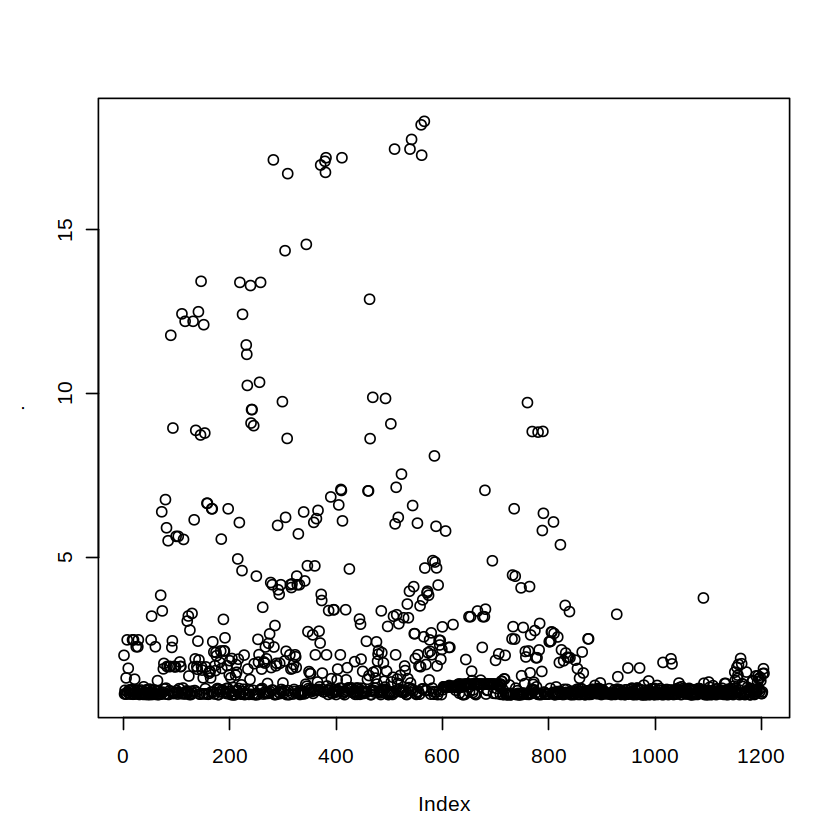

In [94]:
QTL_df %>% pull(nom_pval) %>% as.numeric() %>% -log10(.) %>% plot()